# Image analysis for control charts for Power Bed Laser Fusion

## Data manipolation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

,t,x,y,z,layer_id,sensor0,sensor1,temp,track_id,track_orient,pos_rel,t_rel
0,127875690.0,38.119,-54.480,8.96,224,800.0,805.0,1580.9,0,271,0.00000,0.0
1,127875700.0,38.118,-54.489,8.96,224,807.0,801.0,1596.0,0,271,0.00721,10.0
2,127875710.0,38.119,-54.498,8.96,224,813.0,809.0,1593.2,0,271,0.01442,20.0
3,127875720.0,38.119,-54.508,8.96,224,813.0,824.0,1573.0,0,271,0.02163,30.0
4,127875730.0,38.121,-54.515,8.96,224,820.0,825.0,1581.0,0,271,0.02884,40.0


Generate a temperature matrix

In [3]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [4]:
digits_round = 1
x_range = (26.292, 38.089)
y_range = (-66.633, -54.62)
#x_range = (27, 37)
#y_range = (-66, -56)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round)

C:\Users\Utente\AppData\Local\Temp\ipykernel_9568\437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
C:\Users\Utente\AppData\Local\Temp\ipykernel_9568\437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


In [5]:
list_25l.shape

(25, 120, 118)

# Detect layer anomalies

In [6]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assume list_25l is a NumPy array of shape (25, 120, 118)
frames = np.array(list_25l)
J, M, N = frames.shape
p = M * N

# Step 1: Reshape each frame to 1D vector and stack them
X = frames.reshape(J, -1)  # Shape: (J, p)

# Step 2: Apply PCA
pca = PCA()
scores = pca.fit_transform(X)

# Step 3: Choose m components explaining ≥80% of variance
explained = np.cumsum(pca.explained_variance_ratio_)
m = np.searchsorted(explained, 0.80) + 1
print(m)
Z = scores[:, :m]
Lambda_inv = np.diag(1 / pca.explained_variance_[:m])

# Step 4: Compute T² for each frame (row-wise)
T2 = np.sum(Z @ Lambda_inv * Z, axis=1)  # Shape: (J,)
print(T2)

10
[ 2.85001298  4.15458999  6.4196856   3.75250546 22.8376916   5.16853417
 22.18512926  1.56111812  6.54400425 10.56595043  6.94537681  6.25547282
 15.44474029 22.37614943  2.78942795 15.62917252  3.19687462  4.63214411
  9.86842585 14.57687332 13.05809344  7.86462256  7.11845994 21.27814437
  2.92680013]


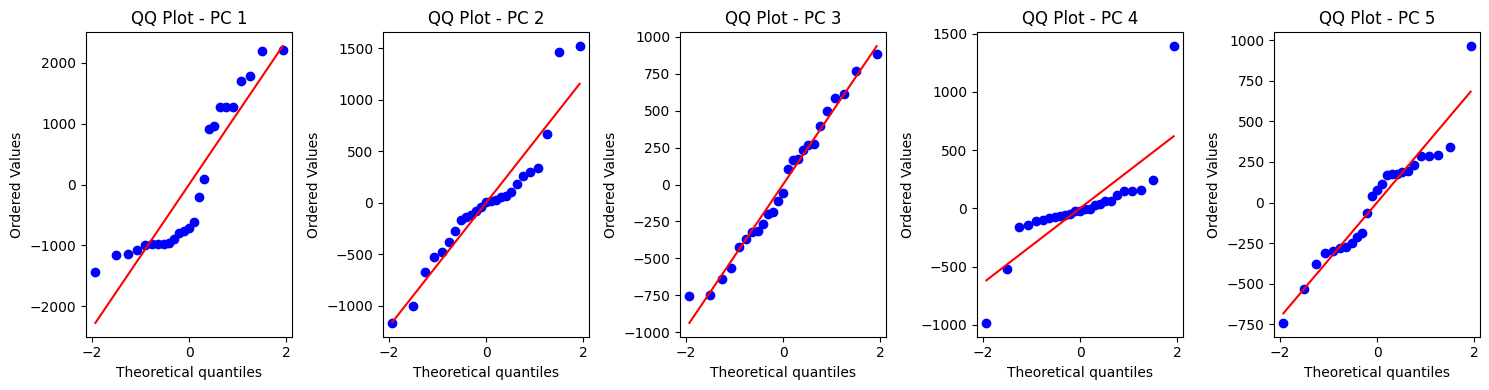

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Z contains the scores (projections) of each frame onto the first m principal components
# Assume you already have: Z = scores[:, :m]

# Choose how many PCs to inspect
num_pcs_to_check = min(5, Z.shape[1])  # Let's check the first 5 PCs (or fewer if m < 5)

fig, axs = plt.subplots(1, num_pcs_to_check, figsize=(15, 4))

for i in range(num_pcs_to_check):
    stats.probplot(Z[:, i], dist="norm", plot=axs[i])
    axs[i].set_title(f'QQ Plot - PC {i+1}')

plt.tight_layout()
plt.show()


c:\Users\Utente\anaconda3\envs\qda_environment\lib\site-packages\qdatoolkit\models.py:723: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


Runs test statistic = 0.501
Runs test p-value = 0.616



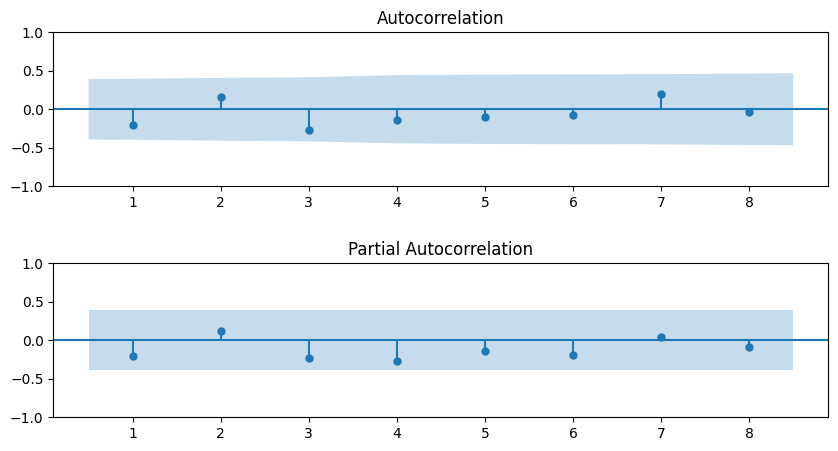

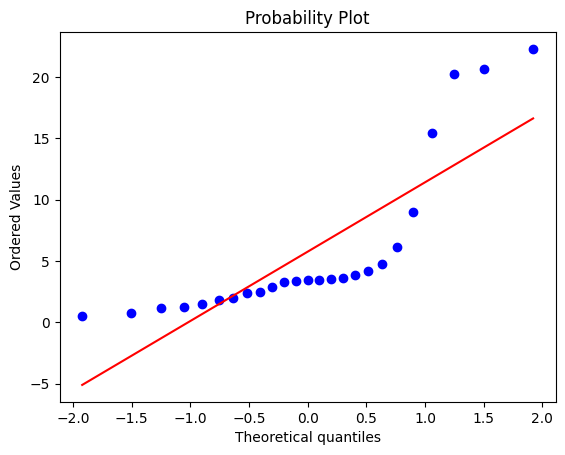

Shapiro-wilk test statistic = 0.686
Shapiro-wilk test p-value = 0.000


In [45]:
import qdatoolkit as qda
runs_statistic, runs_pvalue = qda.Assumptions(T2).independence()

sw_statistic, sw_pvalue = qda.Assumptions(T2).normality()

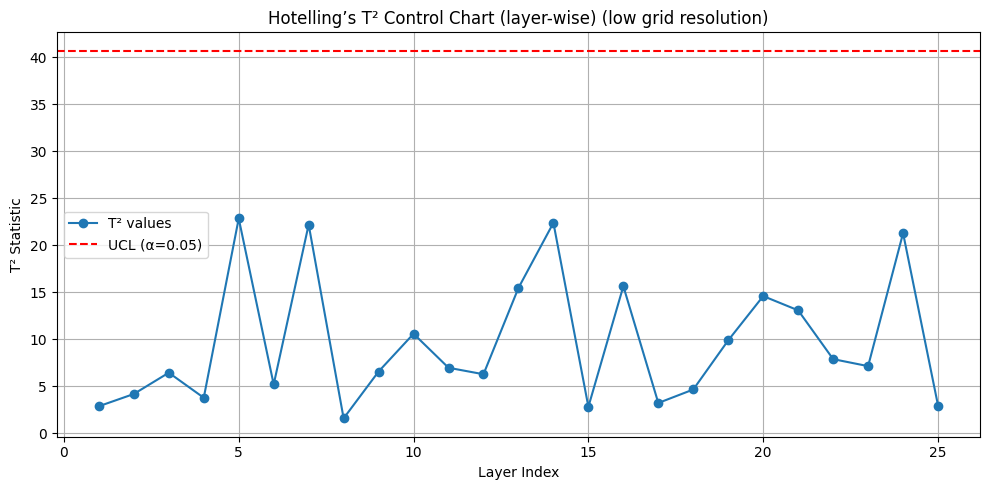

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f

# --- Assume you already have T2 from traditional unfolding PCA ---
# Shape of T2: (J,), where J = number of frames
J = len(T2)
m = Z.shape[1]  # Number of retained principal components

# --- Compute UCL using F-distribution ---
alpha = 0.05  # Significance level
UCL = (m * (J - 1) / (J - m)) * f.ppf(1 - alpha, m, J - m)

# --- Control chart ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, J + 1), T2, marker='o', label="T² values")
plt.axhline(y=UCL, color='r', linestyle='--', label=f'UCL (α={alpha})')
plt.title("Hotelling’s T² Control Chart (layer-wise) (low grid resolution)")
plt.xlabel("Layer Index")
plt.ylabel("T² Statistic")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


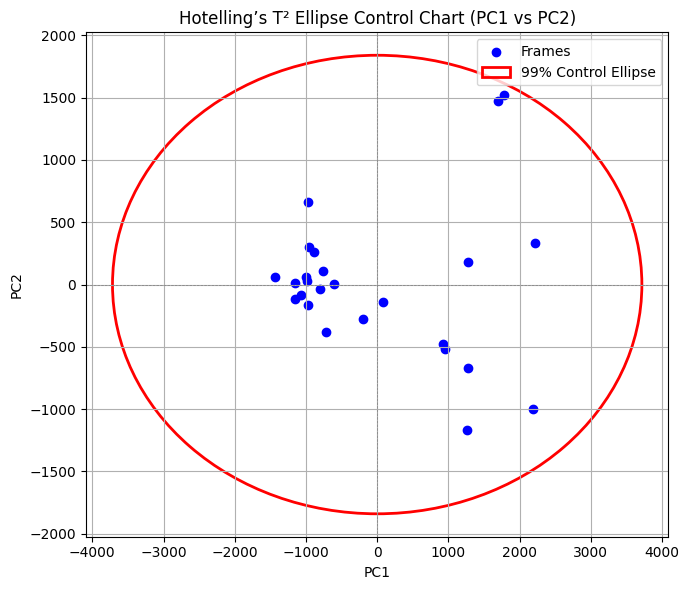

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2

# Assume you already have:
# Z = scores[:, :2]  # First two principal components (shape: J × 2)
Z2 = Z[:, :2]  # Get first two PCs
J = Z2.shape[0]

# Compute mean and covariance of the 2D scores
mu = np.mean(Z2, axis=0)
cov = np.cov(Z2.T)

# Get the Mahalanobis distance threshold from Chi-squared dist with 2 df
alpha = 0.01  # 99% confidence ellipse
threshold = chi2.ppf(1 - alpha, df=2)

# Eigen-decomposition for ellipse axes
eigvals, eigvecs = np.linalg.eigh(cov)
order = eigvals.argsort()[::-1]
eigvals, eigvecs = eigvals[order], eigvecs[:, order]

# Width and height of ellipse (2*sqrt for full width)
width, height = 2 * np.sqrt(threshold * eigvals)
angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))

# Plot
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(Z2[:, 0], Z2[:, 1], c='blue', label='Frames')
ellipse = Ellipse(xy=mu, width=width, height=height, angle=angle,
                  edgecolor='red', fc='None', lw=2, label='99% Control Ellipse')
ax.add_patch(ellipse)

ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Hotelling’s T² Ellipse Control Chart (PC1 vs PC2)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


# References
* [In-Process Monitoring of Selective Laser Melting: Spatial Detection of Defects Via Image Data Analysis](https://re.public.polimi.it/bitstream/11311/1016879/6/in-process%20monitoring%20of%20slm.pdf)

# Further improvements